In [1]:
import pandas as pd
import numpy as np
import difflib
import matplotlib.pyplot as plt
import operator
from scipy import spatial
import pdb
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
movies_dataset = pd.read_csv("Datasets_LIME/movies_metadata.csv")
credits_dataset = pd.read_csv("Datasets_LIME/credits.csv")
keywords_dataset = pd.read_csv("Datasets_LIME/keywords.csv")

/var/folders/3_/dtphwb0543vbjhc431gs6dzc0000gn/T/ipykernel_23589/2840928634.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_dataset = pd.read_csv("Datasets_LIME/movies_metadata.csv")


In [3]:
movies_dataset.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [4]:
movies_dataset.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [5]:
credits_dataset.head(1)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862


In [6]:
movies_dataset.drop(['poster_path','spoken_languages','status'  ,'video','revenue','adult','belongs_to_collection','budget','homepage','imdb_id'], axis = 1,inplace=True)

In [7]:
movies_dataset.columns

Index(['genres', 'id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [8]:
credits_dataset['crew'] = credits_dataset['crew'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x if i['job'] == 'Director'] if isinstance(x, list) else [])
credits_dataset.rename(columns = {'crew':'Director'}, inplace = True)
credits_dataset

,cast,Director,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...",[John Lasseter],862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...",[Joe Johnston],8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...",[Howard Deutch],15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...",[Forest Whitaker],31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...",[Charles Shyer],11862
...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...",[Hamid Nematollah],439050
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...",[Lav Diaz],111109
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...",[Mark L. Lester],67758
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...",[Yakov Protazanov],227506


In [9]:
index = movies_dataset.index
condition = movies_dataset['id'].str.contains(pat = '-')
wrong = index[condition]
wrong
movies_dataset.drop(wrong, inplace = True)
# movies_dataset['id'][35587]

In [10]:
# Converting JSON to List 
credits_dataset['cast'] = credits_dataset['cast'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_dataset['production_companies'] = movies_dataset['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_dataset['genres'] = movies_dataset['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
keywords_dataset['keywords'] = keywords_dataset['keywords'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_dataset['production_countries'] = movies_dataset['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
credits_dataset

,cast,Director,id
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[John Lasseter],862
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",[Joe Johnston],8844
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",[Howard Deutch],15602
3,"[Whitney Houston, Angela Bassett, Loretta Devi...",[Forest Whitaker],31357
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...",[Charles Shyer],11862
...,...,...,...
45471,"[Leila Hatami, Kourosh Tahami, Elham Korda]",[Hamid Nematollah],439050
45472,"[Angel Aquino, Perry Dizon, Hazel Orencio, Joe...",[Lav Diaz],111109
45473,"[Erika Eleniak, Adam Baldwin, Julie du Page, J...",[Mark L. Lester],67758
45474,"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...",[Yakov Protazanov],227506


In [11]:
keywords_dataset

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."
...,...,...
46414,439050,[tragic love]
46415,111109,"[artist, play, pinoy]"
46416,67758,[]
46417,227506,[]


In [12]:
# converting ID column type object to integer
movies_dataset['id'].dtypes
movies_dataset['id'] = movies_dataset['id'].astype(str).astype(int)

In [13]:
# Merging all three datasets(credits_dataset,movies_dataset,keywords_dataset) using ID.
movies_dataset['id'] = movies_dataset['id'].astype(int)
movies = movies_dataset.merge(credits_dataset,on='id',how='left')
movies = movies.merge(keywords_dataset,on='id',how='left')
movies.columns


Index(['genres', 'id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'Director', 'keywords'],
      dtype='object')

In [14]:
movies.shape

(46629, 17)

In [15]:
# Removing all the movie rows with less than 1 vote.

zero_votes = []
for i,j in zip(movies.index,movies.vote_count):
  if j<1:
    zero_votes.append(i)

zero_votes = list(set(zero_votes))
len(zero_votes)
movies.drop(zero_votes,axis=0,inplace=True)

In [16]:
# Removing all the movie rows with empty genres list.

zero_genres = []
for i,j in zip(movies.index,movies.genres):
  if len(j) == 0:
    zero_genres.append(i)
len(zero_genres)

1790

In [17]:
movies.drop(zero_genres,axis=0,inplace=True)

In [18]:
movies.shape

(41817, 17)

In [19]:
# Function to convert list into binary list.

def binary_genres(x):
    binaryList = []
    for genre in genre_list:
        if genre in x:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList
def binary_cast(x):
    binaryList = []
    for cast in lis_cast_bin:
        if cast in x:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList
def binary_director(x):
    binaryList = []
    for director in director_list:
        if director in x:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList
def binary_keywords(x):
    binaryList = []
    for key in keywords_list_bin:
        if key in x:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

In [20]:
movie_genre_popularity = pd.DataFrame()
movie_genre_popularity['genres'] = movies.genres
movie_genre_popularity['original_title'] = movies.original_title
movie_genre_popularity['popularity'] = movies.popularity

movie_genre_popularity

,genres,original_title,popularity
0,"[Animation, Comedy, Family]",Toy Story,21.946943
1,"[Adventure, Fantasy, Family]",Jumanji,17.015539
2,"[Romance, Comedy]",Grumpier Old Men,11.7129
3,"[Comedy, Drama, Romance]",Waiting to Exhale,3.859495
4,[Comedy],Father of the Bride Part II,8.387519
...,...,...,...
46622,[Science Fiction],Caged Heat 3000,0.661558
46623,"[Drama, Action, Romance]",Robin Hood,5.683753
46624,"[Drama, Family]",رگ خواب,0.072051
46625,[Drama],Siglo ng Pagluluwal,0.178241


In [21]:
movie_genre_popularity['popularity'].dtype

dtype('O')

In [22]:
movie_genre_popularity['popularity'] = movie_genre_popularity['popularity'].astype(float)
movie_genre_popularity.sort_values('popularity',ascending=False,inplace=True)
movie_genre_popularity

,genres,original_title,popularity
30876,"[Family, Animation, Adventure, Comedy]",Minions,547.488298
33535,"[Action, Adventure, Fantasy]",Wonder Woman,294.337037
43376,"[Family, Fantasy, Romance]",Beauty and the Beast,287.253654
44798,"[Action, Crime]",Baby Driver,228.032744
24603,"[Adventure, Family, Animation, Action, Comedy]",Big Hero 6,213.849907
...,...,...,...
30320,"[Thriller, Crime, Drama]",Dögkeselyű,0.000001
19845,"[Action, Thriller, Drama]",Midnight Man,NaN
29676,"[Animation, Science Fiction]",マルドゥック・スクランブル 排気,NaN
35970,"[TV Movie, Action, Horror, Science Fiction]",Avalanche Sharks,NaN


In [23]:
movie_genre_popularity_romcom = movie_genre_popularity

In [24]:
# Filtering top 15 rom com movies.
c = 0
ind_romcom = []
for i,j in zip(movie_genre_popularity_romcom['genres'],movie_genre_popularity_romcom.index):
  if "Romance" in i and "Comedy" in i :
    ind_romcom.append(j)
    c+=1
  if c==15:
    break
# ind_romcom 

In [25]:
movie_genre_popularity_romcom = movie_genre_popularity_romcom.loc[ind_romcom]
movie_genre_popularity_romcom

,genres,original_title,popularity
351,"[Comedy, Drama, Romance]",Forrest Gump,48.307194
10357,"[Comedy, Drama, Romance]",Dilwale Dulhania Le Jayenge,34.457024
43359,"[Comedy, Drama, Romance]",The Big Sick,23.424794
46600,"[Family, Animation, Romance, Comedy]",In a Heartbeat,20.821780
5934,"[Comedy, Romance]",The Woman in Red,19.856025
42036,"[Comedy, Drama, Music, Romance]",La La Land,19.681686
2606,"[Comedy, Romance]",American Pie,18.344227
1797,"[Action, Adventure, Comedy, Romance]",Six Days Seven Nights,18.324219
1195,"[Comedy, Drama, Romance]",Annie Hall,18.146043
43958,"[Romance, War, Comedy, Drama]",Their Finest,17.958512


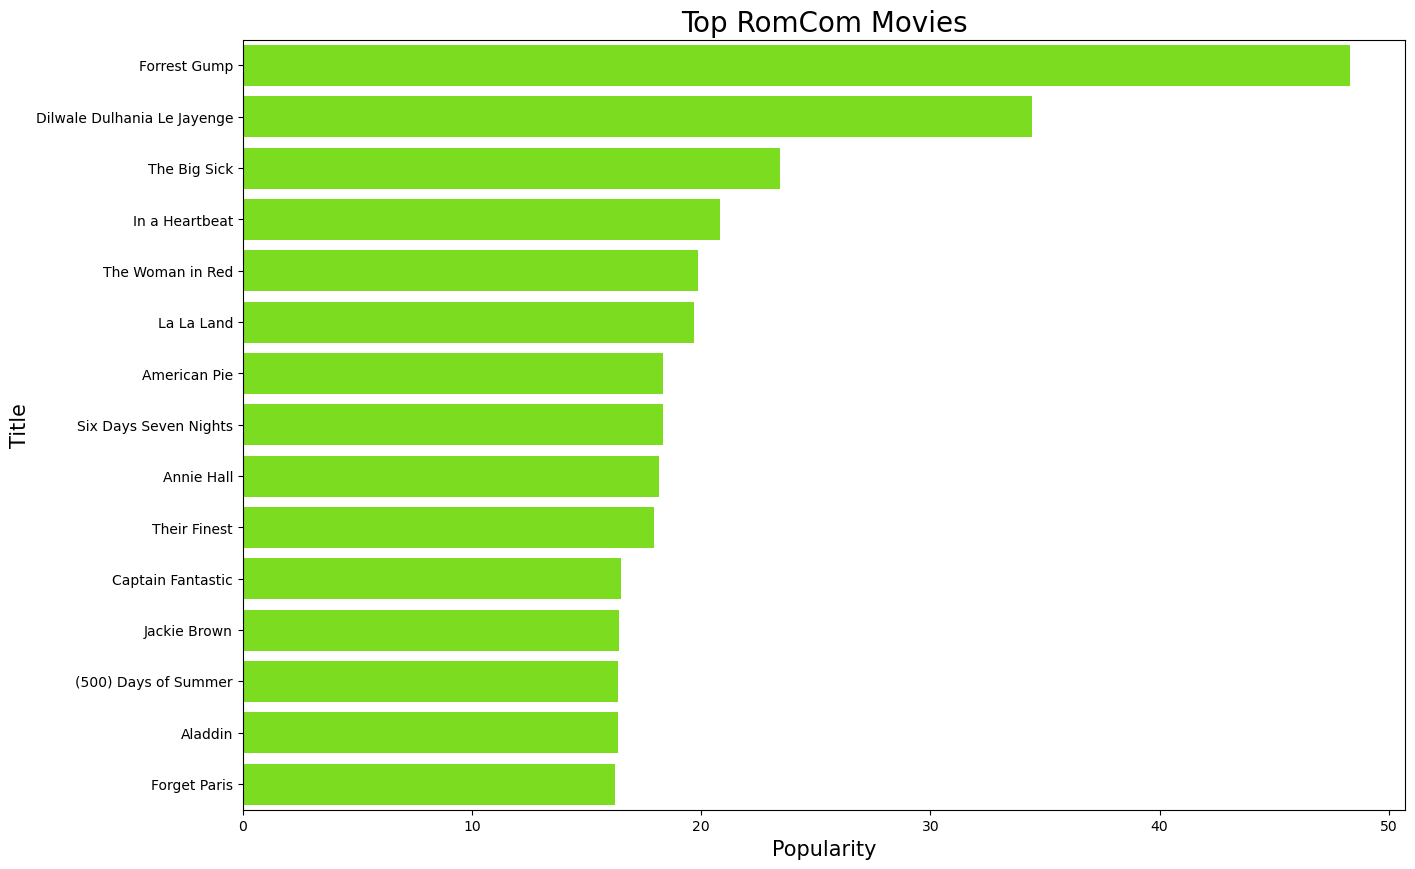

In [26]:
plt.rcParams['figure.figsize'] = [15,10]

romcom_graph = sns.barplot( x = movie_genre_popularity_romcom["popularity"],y = movie_genre_popularity_romcom.original_title.values, color='lawngreen')
romcom_graph.set_xlabel("Popularity", fontsize = 15)
romcom_graph.set_ylabel("Title", fontsize = 15)
romcom_graph.set_title("Top RomCom Movies", fontsize = 20)
plt.show()

In [27]:
# Filtering top 15 Action Drama movies.
movie_genre_popularity_actdrama = movie_genre_popularity
c = 0
ind_actdrama = []
for i,j in zip(movie_genre_popularity_actdrama['genres'],movie_genre_popularity_actdrama.index):
  if "Action" in i and "Drama" in i :
    ind_actdrama.append(j)
    c+=1
  if c==15:
    break
# ind_actdrama 
movie_genre_popularity_actdrama = movie_genre_popularity_actdrama.loc[ind_actdrama]

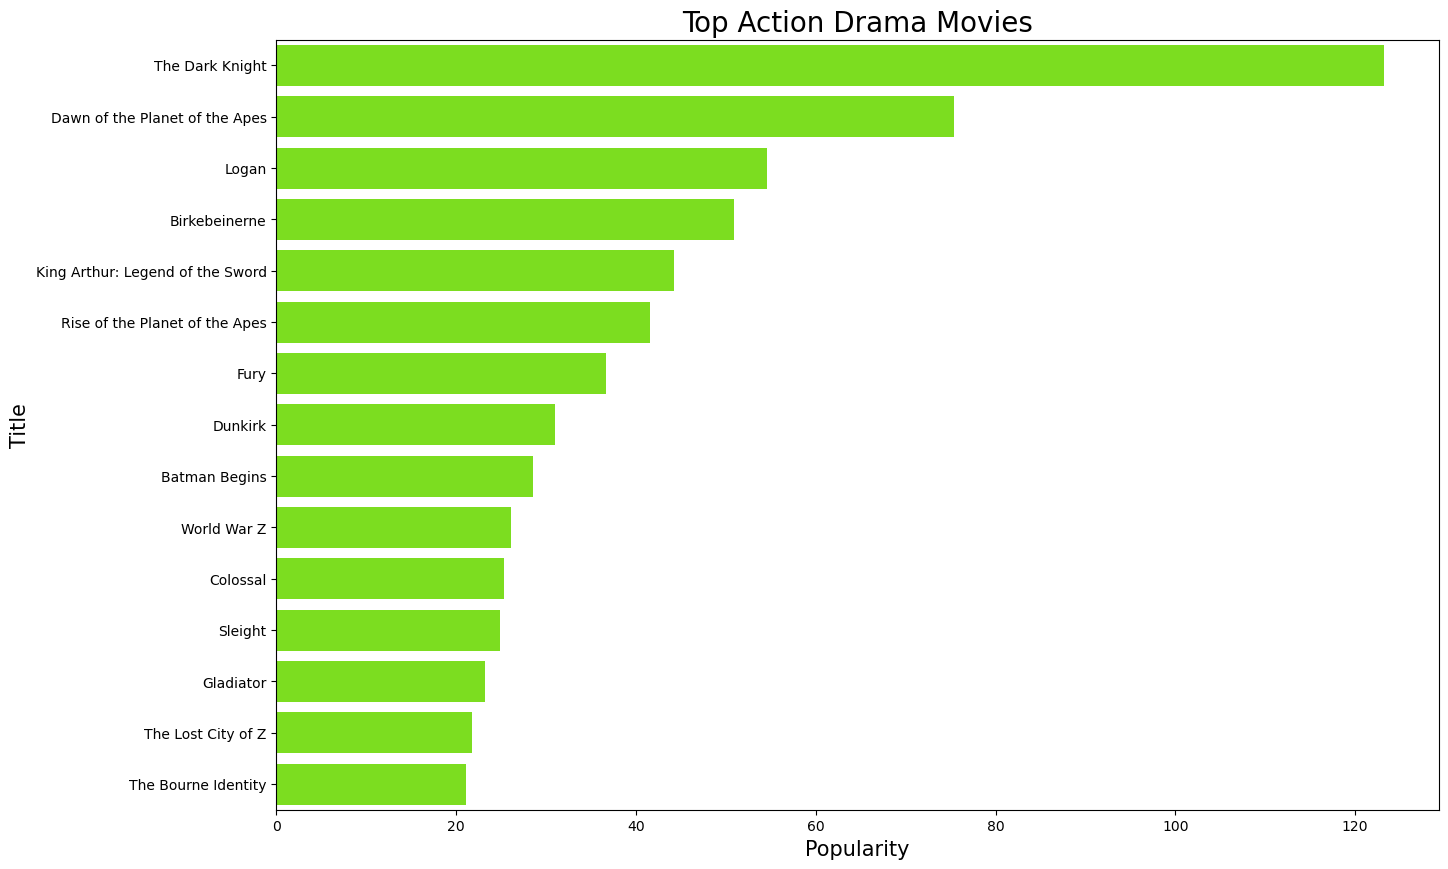

In [28]:
plt.rcParams['figure.figsize'] = [15,10]

actdrama_graph = sns.barplot( x = movie_genre_popularity_actdrama["popularity"], y = movie_genre_popularity_actdrama.original_title.values, color='lawngreen')
actdrama_graph.set_xlabel("Popularity", fontsize = 15)
actdrama_graph.set_ylabel("Title", fontsize = 15)
actdrama_graph.set_title("Top Action Drama Movies", fontsize = 20)
plt.show()

In [29]:
# Filtering top 15 Thriller Crime movies.
movie_genre_popularity_thrillercrime = movie_genre_popularity
c = 0
ind_crithri = []
for i,j in zip(movie_genre_popularity_thrillercrime['genres'],movie_genre_popularity_thrillercrime.index):
  if "Thriller" in i or "Crime" in i :
    ind_crithri.append(j)
    c+=1
  if c==15:
    break
# ind_crithri 
movie_genre_popularity_thrillercrime = movie_genre_popularity_thrillercrime.loc[ind_crithri]

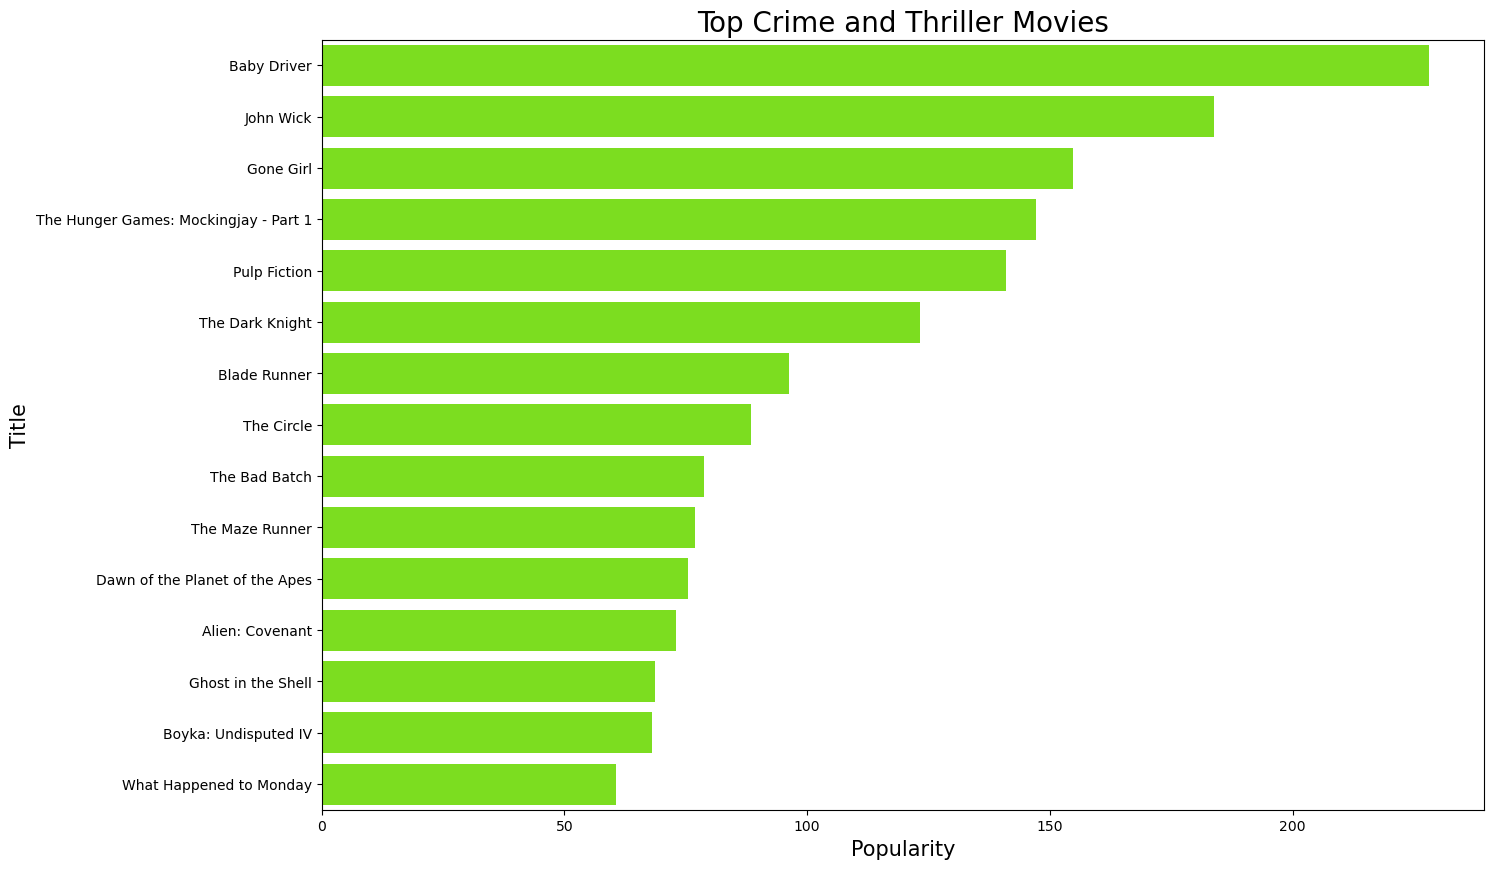

In [30]:
plt.rcParams['figure.figsize'] = [15,10]

crithri_graph = sns.barplot( x = movie_genre_popularity_thrillercrime["popularity"], y = movie_genre_popularity_thrillercrime.original_title.values, color='lawngreen')
crithri_graph.set_xlabel("Popularity", fontsize = 15)
crithri_graph.set_ylabel("Title", fontsize = 15)
crithri_graph.set_title("Top Crime and Thriller Movies", fontsize = 20)
plt.show()

In [31]:
movie_genre_popularity_animation = movie_genre_popularity
c = 0
ind_ani = []
for i,j in zip(movie_genre_popularity_animation['genres'],movie_genre_popularity_animation.index):
  if "Animation" in i :
    ind_ani.append(j)
    c+=1
  if c==18:
    break
# ind_ani 
movie_genre_popularity_animation = movie_genre_popularity_animation.loc[ind_ani]
movie_genre_popularity_animation.drop([5505,42554,41402], axis=0, inplace=True)


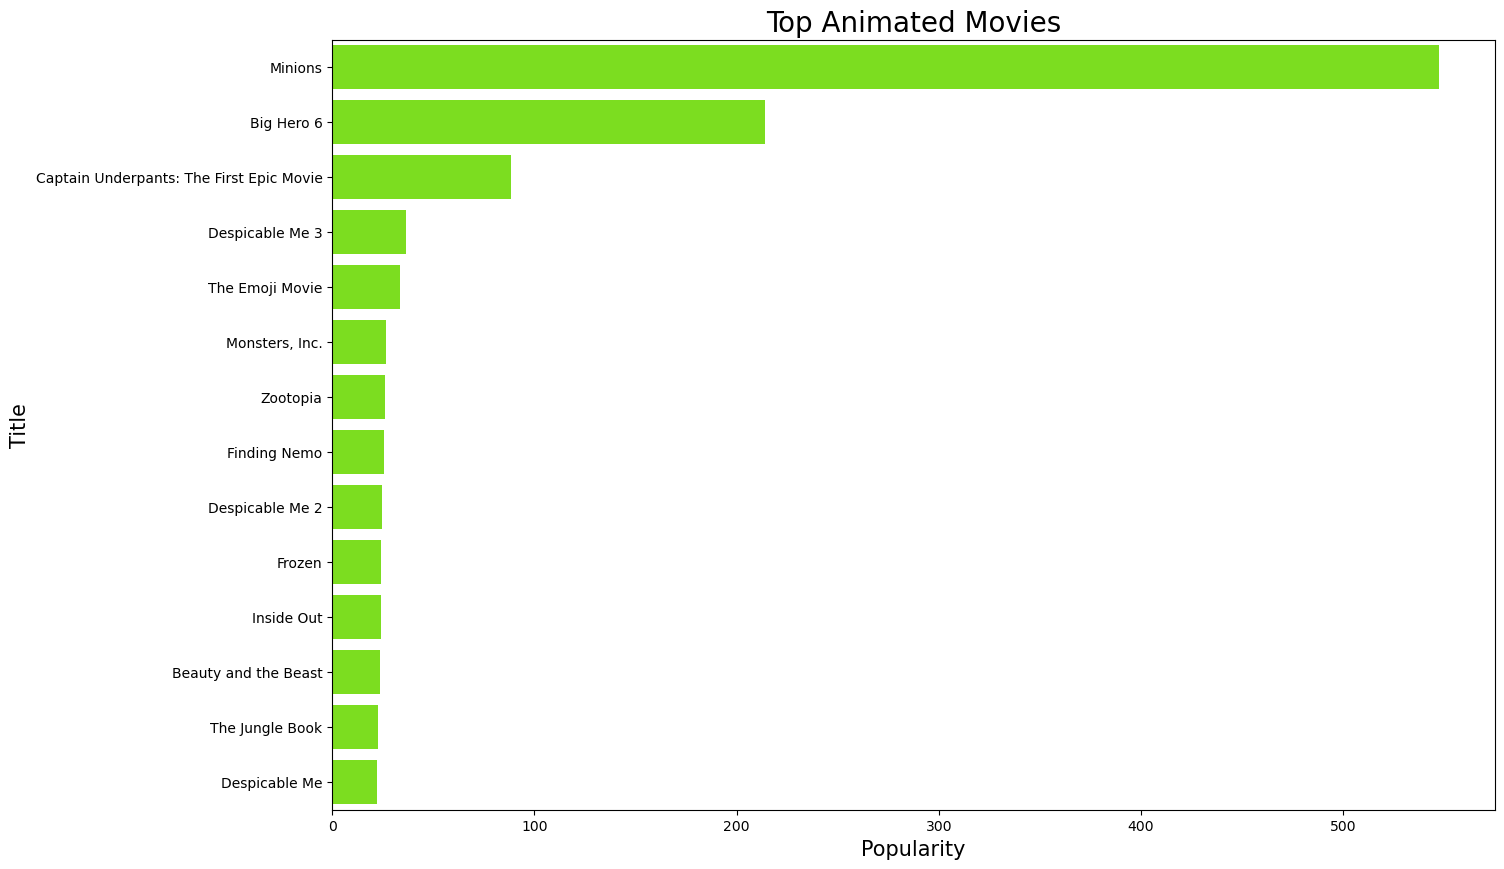

In [32]:
plt.rcParams['figure.figsize'] = [15,10]

Animated_graph = sns.barplot( x = movie_genre_popularity_animation["popularity"], y = movie_genre_popularity_animation.original_title.values, color='lawngreen')
Animated_graph.set_xlabel("Popularity", fontsize = 15)
Animated_graph.set_ylabel("Title", fontsize = 15)
Animated_graph.set_title("Top Animated Movies", fontsize = 20)
plt.show()

In [33]:
movie_genre_popularity = movie_genre_popularity.head(15)

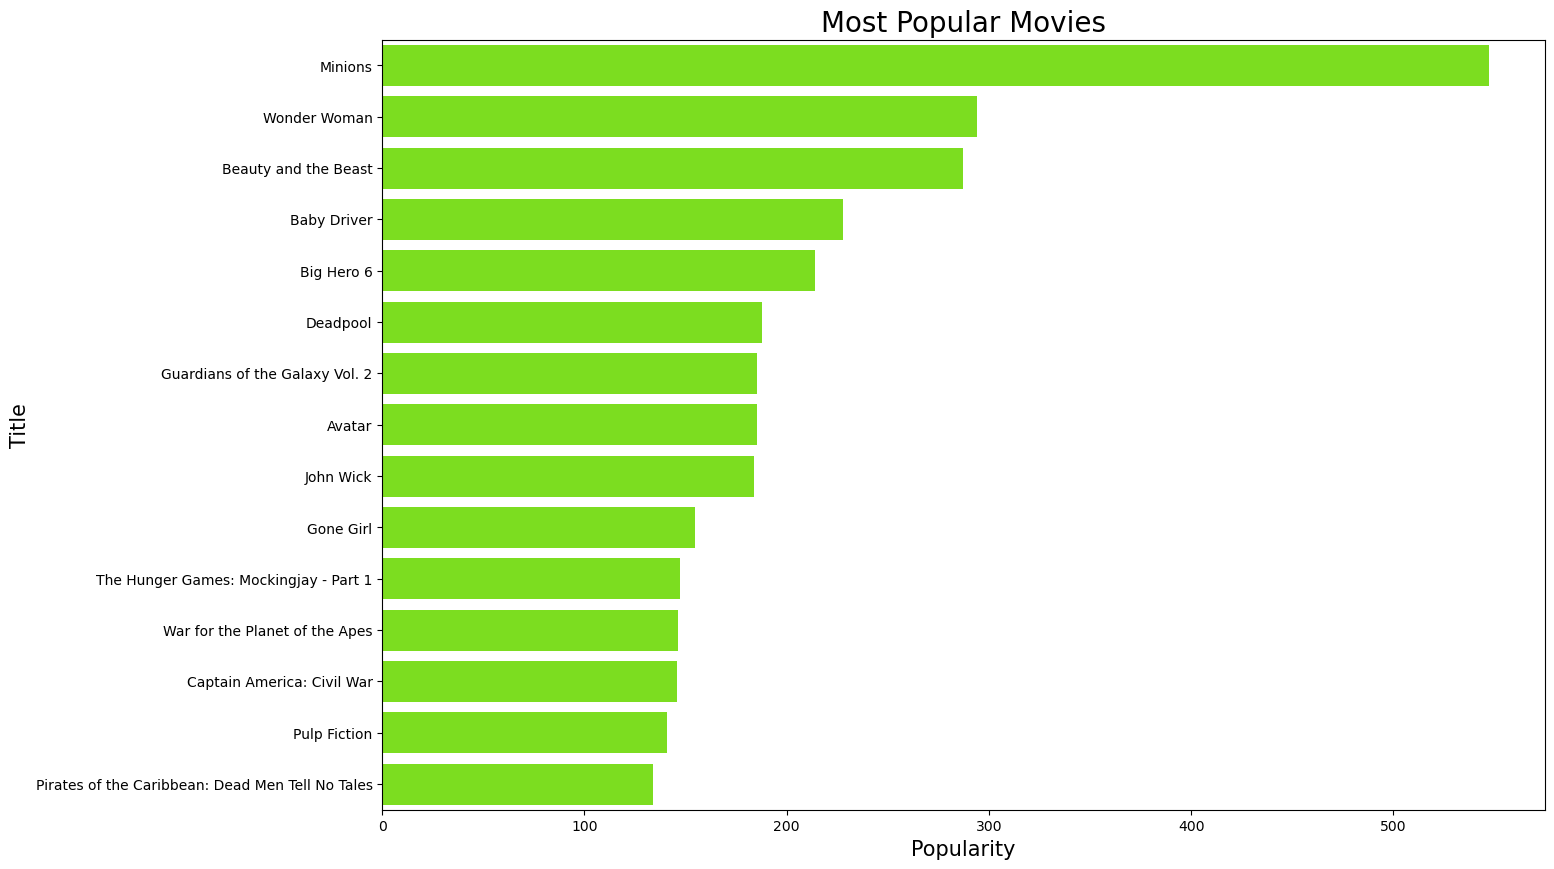

In [34]:
plt.rcParams['figure.figsize'] = [15,10]

popular_graph = sns.barplot( x = movie_genre_popularity["popularity"],y = movie_genre_popularity.original_title.values, color='lawngreen')
popular_graph.set_xlabel("Popularity", fontsize = 15)
popular_graph.set_ylabel("Title", fontsize = 15)
popular_graph.set_title("Most Popular Movies", fontsize = 20)
plt.show()

In [35]:
movies_genres = pd.DataFrame()
movies_genres['genres'] = movies.genres
# movies_genres

In [36]:
# Count of each genre
d = dict()
for i in movies_genres['genres']:
  for j in i:
    if j in d:
      d[j] +=1
    else:
      d[j] = 1
movies_genres_df = pd.DataFrame(d.items(), columns=['genre', 'total'])
movies_genres_df

,genre,total
0,Animation,1944
1,Comedy,12892
2,Family,2744
3,Adventure,3467
4,Fantasy,2327
5,Romance,6649
6,Drama,19877
7,Action,6536
8,Crime,4229
9,Thriller,7632


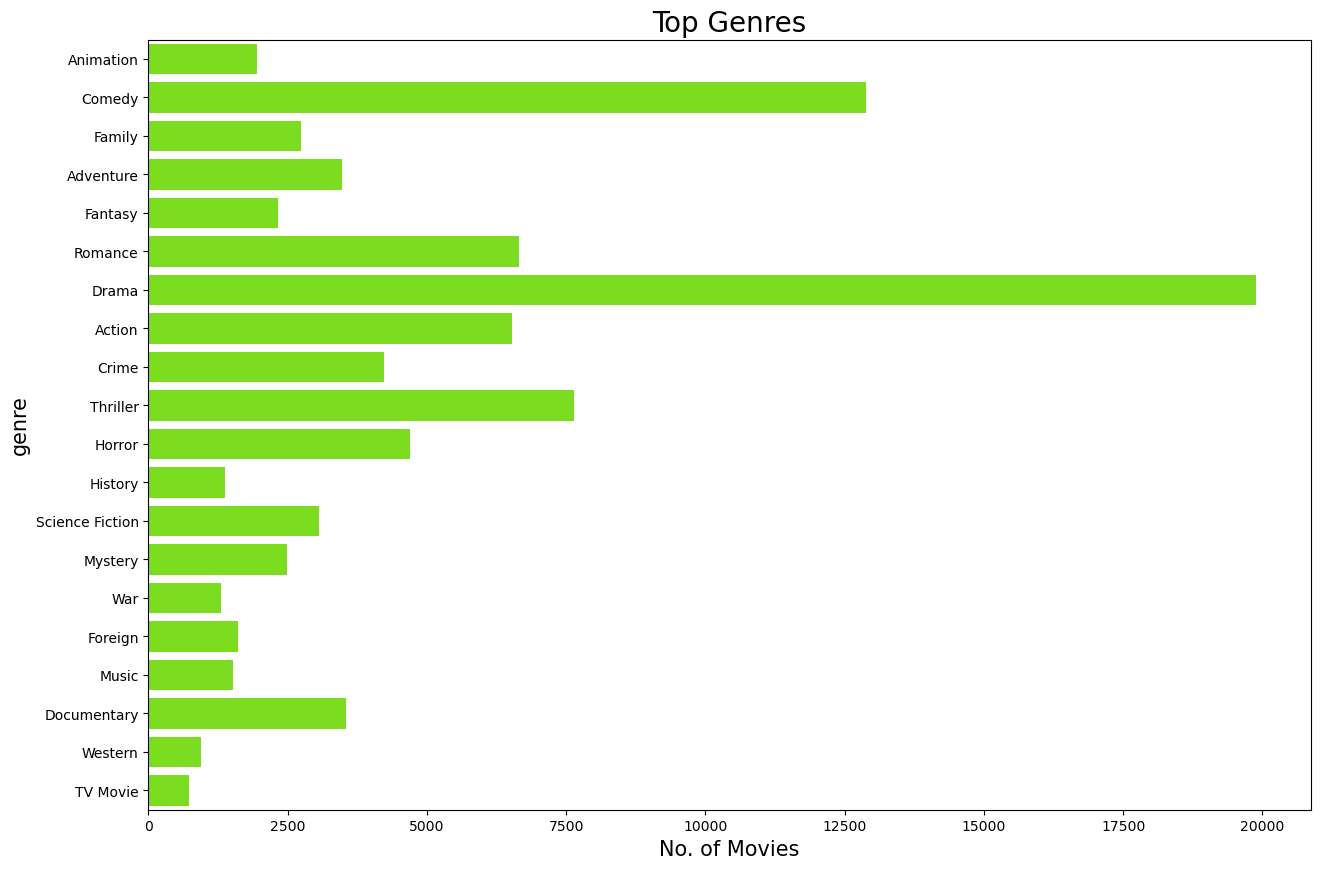

In [37]:
plt.rcParams['figure.figsize'] = [15,10]

genre_graph = sns.barplot( x = movies_genres_df["total"],y = movies_genres_df.genre.values, color='lawngreen')
genre_graph.set_xlabel("No. of Movies", fontsize = 15)
genre_graph.set_ylabel("genre", fontsize = 15)
genre_graph.set_title("Top Genres", fontsize = 20)
plt.show()


In [38]:
genre_list = []
lis = movies_genres_df['genre']
for i in lis:
    genre_list.append(i)
# genre_list
movies['genres_bin'] = movies['genres'].apply(lambda x: binary_genres(x))
movies['genres_bin'].head()

0    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: genres_bin, dtype: object

In [39]:
movies_cast = pd.DataFrame()
movies_cast['cast'] = movies.cast
movies_cast.dropna(subset=['cast'],inplace=True)
movies_cast

,cast
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,"[Whitney Houston, Angela Bassett, Loretta Devi..."
4,"[Steve Martin, Diane Keaton, Martin Short, Kim..."
...,...
46622,"[Lisa Boyle, Kena Land, Zaneta Polard, Don Yan..."
46623,"[Patrick Bergin, Uma Thurman, David Morrissey,..."
46624,"[Leila Hatami, Kourosh Tahami, Elham Korda]"
46625,"[Angel Aquino, Perry Dizon, Hazel Orencio, Joe..."


In [40]:
# Creating df for actors with most appearances.
cast_d = dict()
for i in movies_cast['cast']:
  for j in i:
    if j in cast_d:
      cast_d[j] +=1
    else:
      cast_d[j] = 1

movies_cast_df = pd.DataFrame(cast_d.items(), columns=['cast', 'total'])
movies_cast_df.sort_values('total',ascending=False,inplace=True)
# movies_cast_df
movies_top_cast_df = movies_cast_df.head(15)
movies_top_cast_df.sort_values('total')

,cast,total
1912,John Goodman,97
1295,Christopher Walken,98
1292,Steve Buscemi,100
82,Danny Trejo,103
69,Robert De Niro,105
260,Frank Welker,106
1701,Jackie Chan,107
15126,Michael Caine,107
10783,John Carradine,108
3067,Donald Sutherland,109


In [41]:
cast_list = []
cast_lis = movies_cast_df['cast']
cast_tot = movies_cast_df['total']
for i,j in zip(cast_lis,cast_tot):
  if j>100:
    cast_list.append(i)
# cast_list

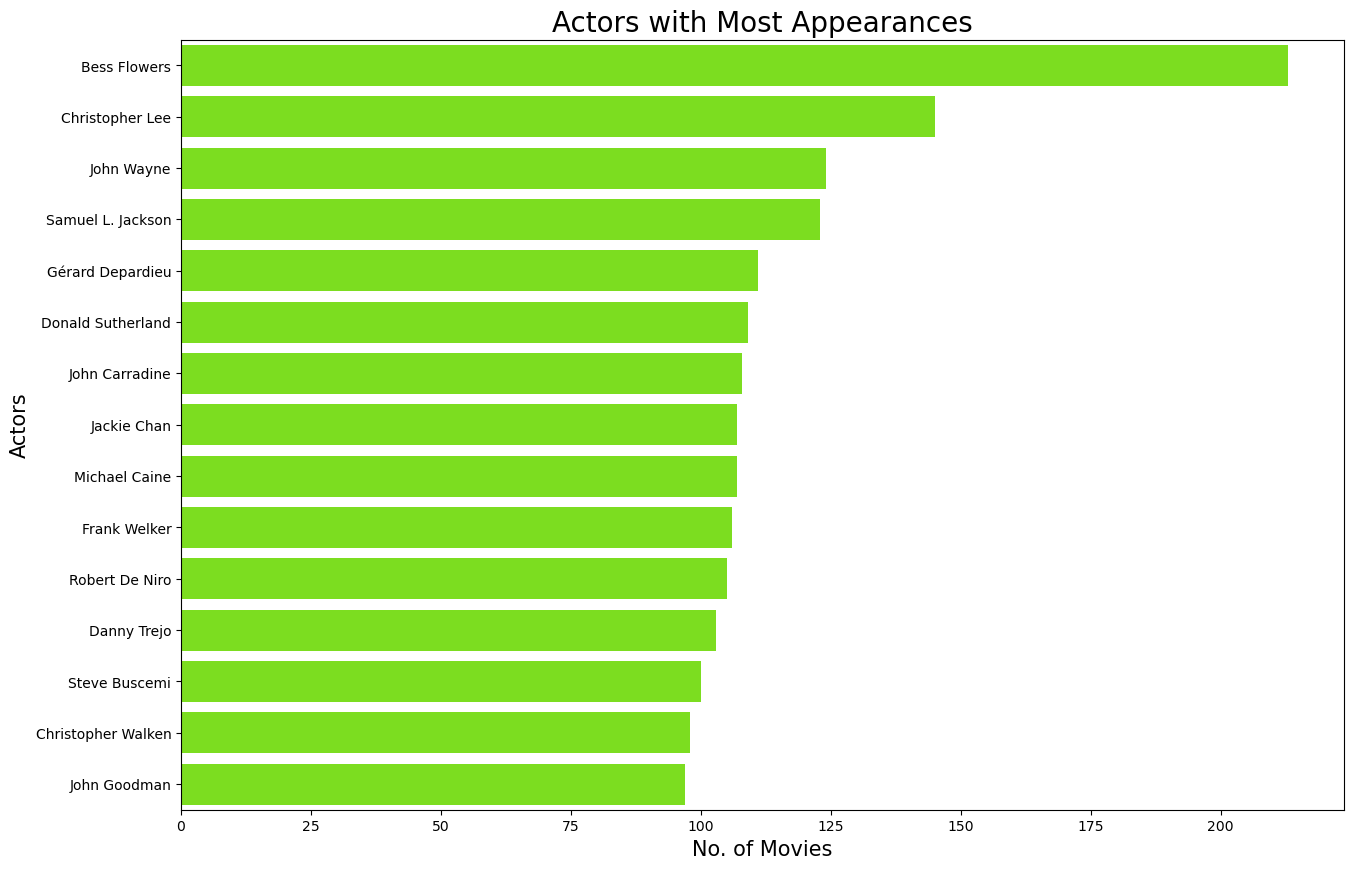

In [42]:
plt.rcParams['figure.figsize'] = [15,10]

cast_graph = sns.barplot( x = movies_top_cast_df["total"], y = movies_top_cast_df.cast, color='lawngreen')
cast_graph.set_xlabel("No. of Movies", fontsize = 15)
cast_graph.set_ylabel("Actors", fontsize = 15)
cast_graph.set_title("Actors with Most Appearances", fontsize = 20)
plt.show()

In [43]:
lis_cast_bin = []
for i in movies_cast['cast']:
    c=0
    l = len(i)
    for j in i:
        if l>30:
            if c>2: break
        elif l<=30 and l>20:
            if c>1: break
        elif l<=20:
            if c>0: break
        c+=1
        lis_cast_bin.append(j)

lis_cast_bin = list(set(lis_cast_bin))
len(lis_cast_bin)
    

19083

In [44]:
movies['cast'].isna().sum()
movies.dropna(subset = ['cast'],inplace=True)

In [45]:
movies['cast_bin'] = movies['cast'].apply(lambda x: binary_cast(x))
movies['cast_bin'].head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: cast_bin, dtype: object

In [46]:
movies['Director']

0           [John Lasseter]
1            [Joe Johnston]
2           [Howard Deutch]
3         [Forest Whitaker]
4           [Charles Shyer]
                ...        
46622       [Aaron Osborne]
46623          [John Irvin]
46624    [Hamid Nematollah]
46625            [Lav Diaz]
46626      [Mark L. Lester]
Name: Director, Length: 41817, dtype: object

In [47]:
director_d = dict()
for i in movies['Director']:
  for j in i:
    if j in director_d:
      director_d[j] +=1
    else:
      director_d[j] = 1

movies_director_df = pd.DataFrame(director_d.items(), columns=['director', 'total'])
# movies_director_df
# len(movies_director_df['total'])
movies_director_df.sort_values('total',ascending=False,inplace=True)

In [48]:
director_list = []
director_lis = movies_director_df['director']
director_tot = movies_director_df['total']
for i,j in zip(director_lis,director_tot):
  if j>1:
    director_list.append(i)

In [49]:
movies_top_directors_df = movies_director_df.head(15)
movies_top_directors_df.sort_values('total')

,director,total
15,Martin Scorsese,41
4061,Georges Méliès,41
1580,Henry Hathaway,41
678,Frank Capra,42
399,Sidney Lumet,43
1772,Raoul Walsh,43
852,Charlie Chaplin,44
2503,Anatole Litvak,44
672,George Cukor,45
546,Jean-Luc Godard,49


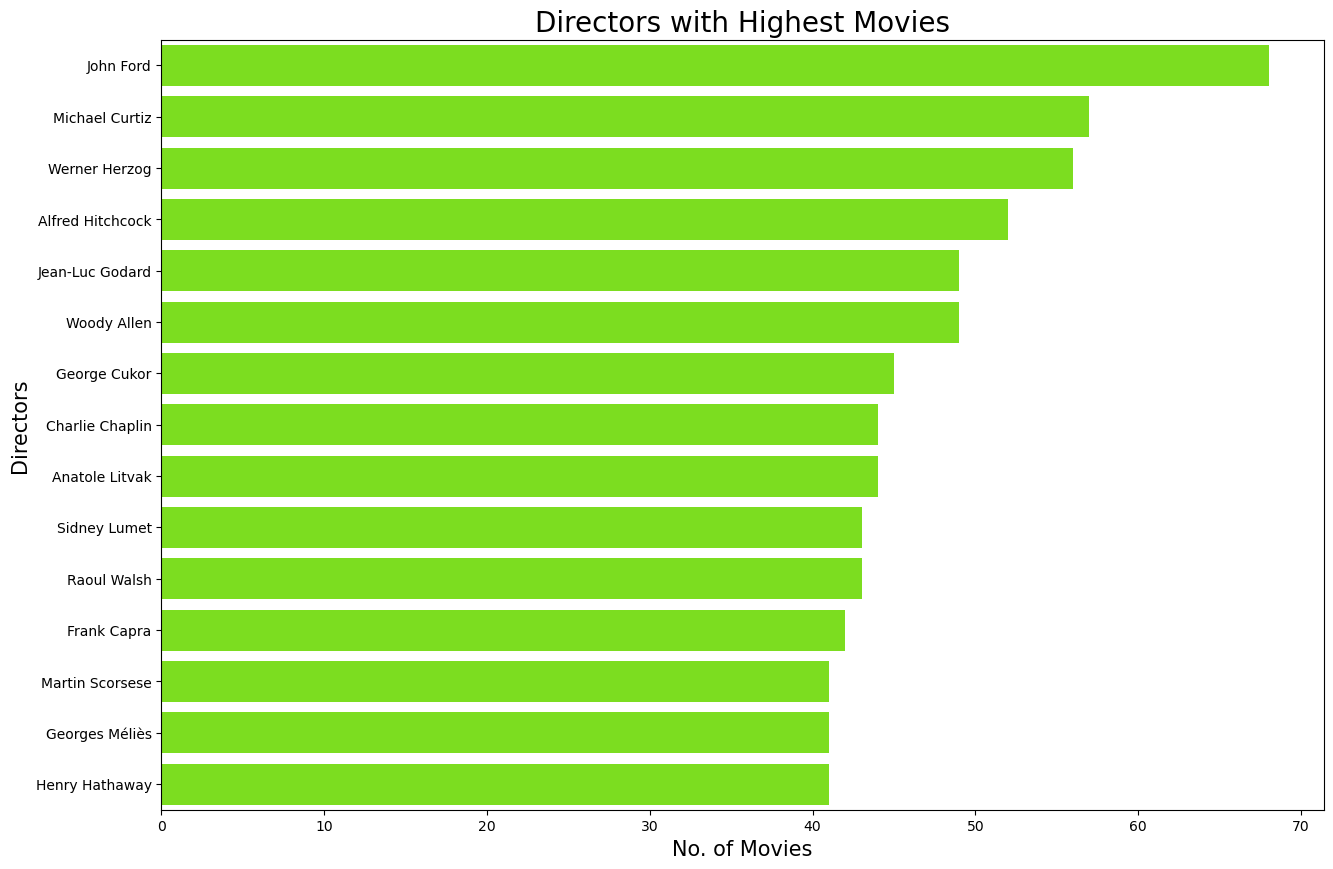

In [50]:
plt.rcParams['figure.figsize'] = [15,10]

director_graph = sns.barplot( x = movies_top_directors_df["total"],y = movies_top_directors_df.director, color='lawngreen')
director_graph.set_xlabel("No. of Movies", fontsize = 15)
director_graph.set_ylabel("Directors", fontsize = 15)
director_graph.set_title("Directors with Highest Movies", fontsize = 20)
plt.show()

In [51]:
movies['director_bin'] = movies['Director'].apply(lambda x: binary_director(x))
movies['director_bin'].head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: director_bin, dtype: object

In [52]:
keywords_dataset

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."
...,...,...
46414,439050,[tragic love]
46415,111109,"[artist, play, pinoy]"
46416,67758,[]
46417,227506,[]


In [53]:
keywords_list = []
for i in keywords_dataset['keywords']:
    for j in i:
        if j not in keywords_list:
            keywords_list.append(j)
len(keywords_list)

19956

In [54]:
keywords_dict = dict()
for i in keywords_dataset['keywords']:
    for j in i:
        if j not in keywords_dict:
            keywords_dict[j] = 1
        else:
            keywords_dict[j] +=1

In [55]:
keywords_df = pd.DataFrame()
keywords_df = pd.DataFrame(keywords_dict.items(), columns=['keywords', 'total'])
keywords_df.sort_values(['total'],ascending=False)

,keywords,total
132,woman director,3115
261,independent film,1930
41,murder,1308
19,based on novel,835
343,musical,734
...,...,...
13704,longest film,1
13702,figher airplane,1
13701,all girl,1
6268,ancient scroll,1


In [56]:
keywords_list_bin = []
for i in keywords_df.keywords:
    keywords_list_bin.append(i)
# keywords_list_bin
# len(keywords_list_bin)

In [57]:
movies['keywords_bin'] = movies['keywords'].apply(lambda x: binary_keywords(x))

In [58]:
movies

,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,...,title,vote_average,vote_count,cast,Director,keywords,genres_bin,cast_bin,director_bin,keywords_bin
0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,81.0,...,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[John Lasseter],"[jealousy, toy, boy, friendship, friends, riva...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
1,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,104.0,...,Jumanji,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",[Joe Johnston],"[board game, disappearance, based on children'...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
2,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,101.0,...,Grumpier Old Men,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",[Howard Deutch],"[fishing, best friend, duringcreditsstinger, o...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,127.0,...,Waiting to Exhale,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...",[Forest Whitaker],"[based on novel, interracial relationship, sin...","[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,106.0,...,Father of the Bride Part II,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...",[Charles Shyer],"[baby, midlife crisis, confidence, aging, daug...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46622,[Science Fiction],222848,en,Caged Heat 3000,It's the year 3000 AD. The world's most danger...,0.661558,[Concorde-New Horizons],[United States of America],1995-01-01,85.0,...,Caged Heat 3000,3.5,1.0,"[Lisa Boyle, Kena Land, Zaneta Polard, Don Yan...",[Aaron Osborne],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
46623,"[Drama, Action, Romance]",30840,en,Robin Hood,"Yet another version of the classic epic, with ...",5.683753,"[Westdeutscher Rundfunk (WDR), Working Title F...","[Canada, Germany, United Kingdom, United State...",1991-05-13,104.0,...,Robin Hood,5.7,26.0,"[Patrick Bergin, Uma Thurman, David Morrissey,...",[John Irvin],[],"[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 

In [61]:
def Similarity(movieId1, movieId2):
    a = movies.iloc[movieId1]
    b = movies.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    castA = a['cast_bin']
    castB = b['cast_bin']
    castDistance = spatial.distance.cosine(castA, castB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)
    
    wordsA = a['keywords_bin']
    wordsB = b['keywords_bin']
    wordsDistance = spatial.distance.cosine(wordsA, wordsB)
    return genreDistance + directDistance + castDistance + wordsDistance

In [62]:
movies.reset_index(inplace=True)

In [63]:
# Distance between movies with IDs 35 and 37 respectively.
Similarity(35,37)

4.0

In [64]:
# Selecting relevant features
new_id = list(range(0,movies.shape[0]))
movies['new_id']=new_id
movies=movies[['original_title','genres','vote_average','genres_bin','cast_bin','new_id','Director','director_bin','keywords_bin']]


In [65]:
movies.head(20)

,original_title,genres,vote_average,genres_bin,cast_bin,new_id,Director,director_bin,keywords_bin
0,Toy Story,"[Animation, Comedy, Family]",7.7,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,[John Lasseter],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
1,Jumanji,"[Adventure, Fantasy, Family]",6.9,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,[Joe Johnston],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
2,Grumpier Old Men,"[Romance, Comedy]",6.5,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,[Howard Deutch],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Waiting to Exhale,"[Comedy, Drama, Romance]",6.1,"[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,[Forest Whitaker],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Father of the Bride Part II,[Comedy],5.7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,[Charles Shyer],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,Heat,"[Action, Crime, Drama, Thriller]",7.7,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,[Michael Mann],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,Sabrina,"[Comedy, Romance]",6.2,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,[Sydney Pollack],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,Tom and Huck,"[Action, Adventure, Drama, Family]",5.4,"[0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,[Peter Hewitt],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,Sudden Death,"[Action, Adventure, Thriller]",5.5,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,[Peter Hyams],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,GoldenEye,"[Adventure, Action, Thriller]",6.6,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,[Martin Campbell],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [66]:
titles_list = movies['original_title'].tolist()

In [67]:
def Recommend_movie(movie_name):
    find_close_match = difflib.get_close_matches(movie_name, titles_list)
    print("Do you mean?")
    for ind in range(len(find_close_match)):
      print(ind+1,".",find_close_match[ind])
    req = int(input("Please select Number: "))
    name = find_close_match[req-1]
    new_movie = movies[movies['original_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Movie: ',new_movie.original_title.values[0])
    def getNeighbors(baseMovie, K):
        distances = []
    
        for index, movie in movies.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)
    
    print('\nRecommended Movies: \n')
    for neighbor in neighbors:
        avgRating = avgRating+movies.iloc[neighbor[0]][2]  
        print( movies.iloc[neighbor[0]][0]+" | Genres: "+str(movies.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+" | Rating: "+str(movies.iloc[neighbor[0]][2]))
    return movie_name
    

In [68]:
Recommend_movie(input('Search movies : '))

Search movies :  Four Rooms


Do you mean?
1 . Four Rooms
2 . Four Sons
3 . Four Lions


Please select Number:  1


Selected Movie:  Four Rooms


/Users/vamsikrishnavajja/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)



Recommended Movies: 

Az éjszakám a nappalod | Genres: 'Crime','Comedy' | Rating: 10.0
Unmade Beds | Genres: 'Comedy' | Rating: 5.0
Ο Ξεναγός | Genres: 'Comedy' | Rating: 10.0
Tom, Dick And Harry | Genres: 'Comedy' | Rating: 6.5
Puolin ja toisin | Genres: 'Comedy' | Rating: 5.0
Lieksa! | Genres: 'Comedy','Drama' | Rating: 5.3
A Very British Gangster | Genres: 'Crime','Documentary' | Rating: 6.1
What's Up, Scarlet? | Genres: 'Comedy','Romance' | Rating: 5.0
The Gay Bed and Breakfast of Terror | Genres: 'Horror','Comedy' | Rating: 3.6
Made For Each Other | Genres: 'Comedy','Romance' | Rating: 6.0


'Four Rooms'